# Data Mining Lab 3 Pipeline Assignment

**Medium articles** are used to disseminate knowledge and are written on a wide range of technical and non-technical topics. Users subscribe to different reading lists where reading lists represent either domains or certain topics. This naturally gives rise to a network structure where articles may belong to the same reading lists and hence are related to each other. Each article belongs to a certain topic. Automatically assigning articles to topics is very valuable for search applications. **The goal of this task is to classify articles by predicting their topics.**

A dataset of medium articles along with subscription lists and topic tags is provided. The task is to classify articles into tags (i.e., topics), leveraging the network structure arising from relations using the subscription lists. Specifically, two nodes are connected if they share at least one list.

**For this task you may only use the following libraries**: `numpy`, `pandas`, `matplotlib`, `networkx`, `gensim`.


In [1]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot
#from gensim.models import Word2Vec

## Data loading

The data is provided in three files which can be found in the `data` directory:

- `articles.csv`: Contains the articles along with the subscription lists and some metadata.
- `test_data.csv`: Contains a subset of nodes (articles) along with their labels (topics) used for testing.
- `train_data.csv`: Contains the remaining nodes (articles) along with their labels (topics).

**Important**: There is no specific training data requried for this assignment, since the node embeddings (task 3) are trained on the entire graph. The nodes in `train_data.csv` must be used for the kNN classifier, i.e., the computed nearest neighbors for a test node may only be nodes from this file.

Let's use `pandas` to read these files:


In [3]:
articles = pd.read_csv(Path("data") / "articles.csv")
articles["node_id"] = articles.index
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

Note that we have assigned node IDs based on where each article is located in the file.

We can now inspect the individual data frames:


In [4]:
articles.head(2)

,article,title,subtitle,author,date,lists,node_id
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,[https://medium.com/@zemmali1990/list/aws-49f6...,0
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,[https://medium.com/@TomaszCieplak/list/graph-...,1


In [5]:
test_data.head(2)

,node_id,label
0,2291,artificial-intelligence
1,7292,artificial-intelligence


Next, let's create our graph. We'll create one node for each article and insert an edge between two articles if they share at least one subscription list:


In [6]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## Tasks

1. Familiarization: Analyze the graph. Compute and plot statistics such as the number of nodes, number of edges, number of neighbors of each node, and so on. Are there any isolated nodes (i.e., nodes that do not have a single neighbor)?
2. Compute spectral node embeddings.
3. Perform random walks on the graph to obtain a set of sequences of nodes. Use those sequences to compute node embeddings. Hint: You may use the Word2vec implementation of the gensim library for this task. By treating each node as a word, this method will give you node embeddings.
4. Implement a simple k-nearest neighbor classifier: For each node (medium article) in the test set, compute its nearest neighbors (based on the similarity of node embeddings). The classifier assigns a label (i.e., a topic) based on the topics of the nearest neighbors. Specifically, the predicted topic is simply the most common topic among the nearest neighbors. Compare both sets of node embeddings in terms of performance. Which one works better?


## 1. Familiarization

Number of nodes in the graph:  27718
Number of edges in the graph:  2014162
Average number of degrees per node:  72.67


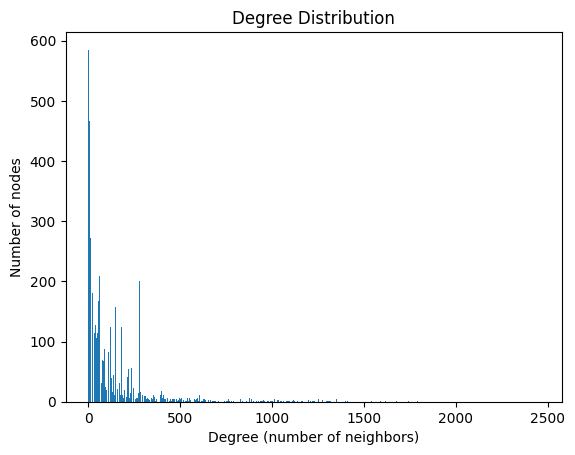

We can see that there are a lot of isolated nodes (nodes with 0 neighbours), namely 347
The node with the highest degree has 2452 neighbours. There are 2 nodes with many neighbours in the graph.


In [35]:
n = len(medium_graph.nodes)
m = len(medium_graph.edges)
print("Number of nodes in the graph: ", n)
print("Number of edges in the graph: ", m)

degree_view = medium_graph.degree
#print(degree_view)
degree_counts = {}
for _, degree in degree_view:
    if degree not in degree_counts:
        degree_counts[degree] = 1
    else:
        degree_counts[degree] += 1
#print(degree_counts)

degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

max_degree = max(degrees)

degree_dict = dict(degree_view)
number_of_isolated_nodes = list(degree_dict.values()).count(0)

degree_list = list(degree_view)
#print("degree_list", degree_list)
sorted_degree_list = sorted(degree_list, key=lambda x: x[1])

print("Average number of degrees per node: ", round(m/n, 2))

pyplot.bar(degrees, counts)
pyplot.xlabel('Degree (number of neighbors)')
pyplot.ylabel('Number of nodes')
pyplot.title('Degree Distribution')
pyplot.show()


#print("sorted list", sorted_degree_list)
print("We can see that there are a lot of isolated nodes (nodes with 0 neighbours), namely", number_of_isolated_nodes)



print("The node with the highest degree has", max_degree, "neighbours. There are", list(degree_dict.values()).count(max_degree), "nodes with many neighbours in the graph.")